## Libraries

In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## Feature Extraction 

In [4]:
def extract_features(filepath):
    y, sr = librosa.load(filepath, sr=22050)

    features = {}

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfcc[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfcc[i])

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(chroma.shape[0]):
        features[f'chroma_{i+1}_mean'] = np.mean(chroma[i])

    # Spectral contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    for i in range(contrast.shape[0]):
        features[f'contrast_{i+1}_mean'] = np.mean(contrast[i])

    # Other spectral features
    features['spec_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spec_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spec_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=y))

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    return features

In [5]:
audio_dir = "../dataset/no_folders"  
dataset = []

for filename in tqdm(os.listdir(audio_dir)):
    if filename.endswith(".wav"):
        filepath = os.path.join(audio_dir, filename)
        genre = filename.split('.')[0]  
        try:
            features = extract_features(filepath)
            features['genre'] = genre
            dataset.append(features)
        except Exception as e:
            print(f"Error with {filename}: {e}")

df = pd.DataFrame(dataset)
df.head()


FileNotFoundError: [WinError 3] The system cannot find the path specified: '../dataset/no_folders'

In [4]:
df.to_csv("../df/test1_features.csv", index=False)

## Visualizing and Analyzing Correlation between features

In [5]:
feature_cols = df.columns.drop('genre') if 'genre' in df.columns else df.columns

# "mean" columns
mean_cols = [col for col in feature_cols if 'mean' in col]
df_mean = df[mean_cols]
corr_mean = df_mean.corr()
corr_mean_lower = corr_mean.where(np.tril(np.ones(corr_mean.shape), k=0).astype(bool))

# "std" columns
std_cols = [col for col in feature_cols if 'std' in col]
df_std = df[std_cols]
corr_std = df_std.corr()
corr_std_lower = corr_std.where(np.tril(np.ones(corr_std.shape), k=0).astype(bool))

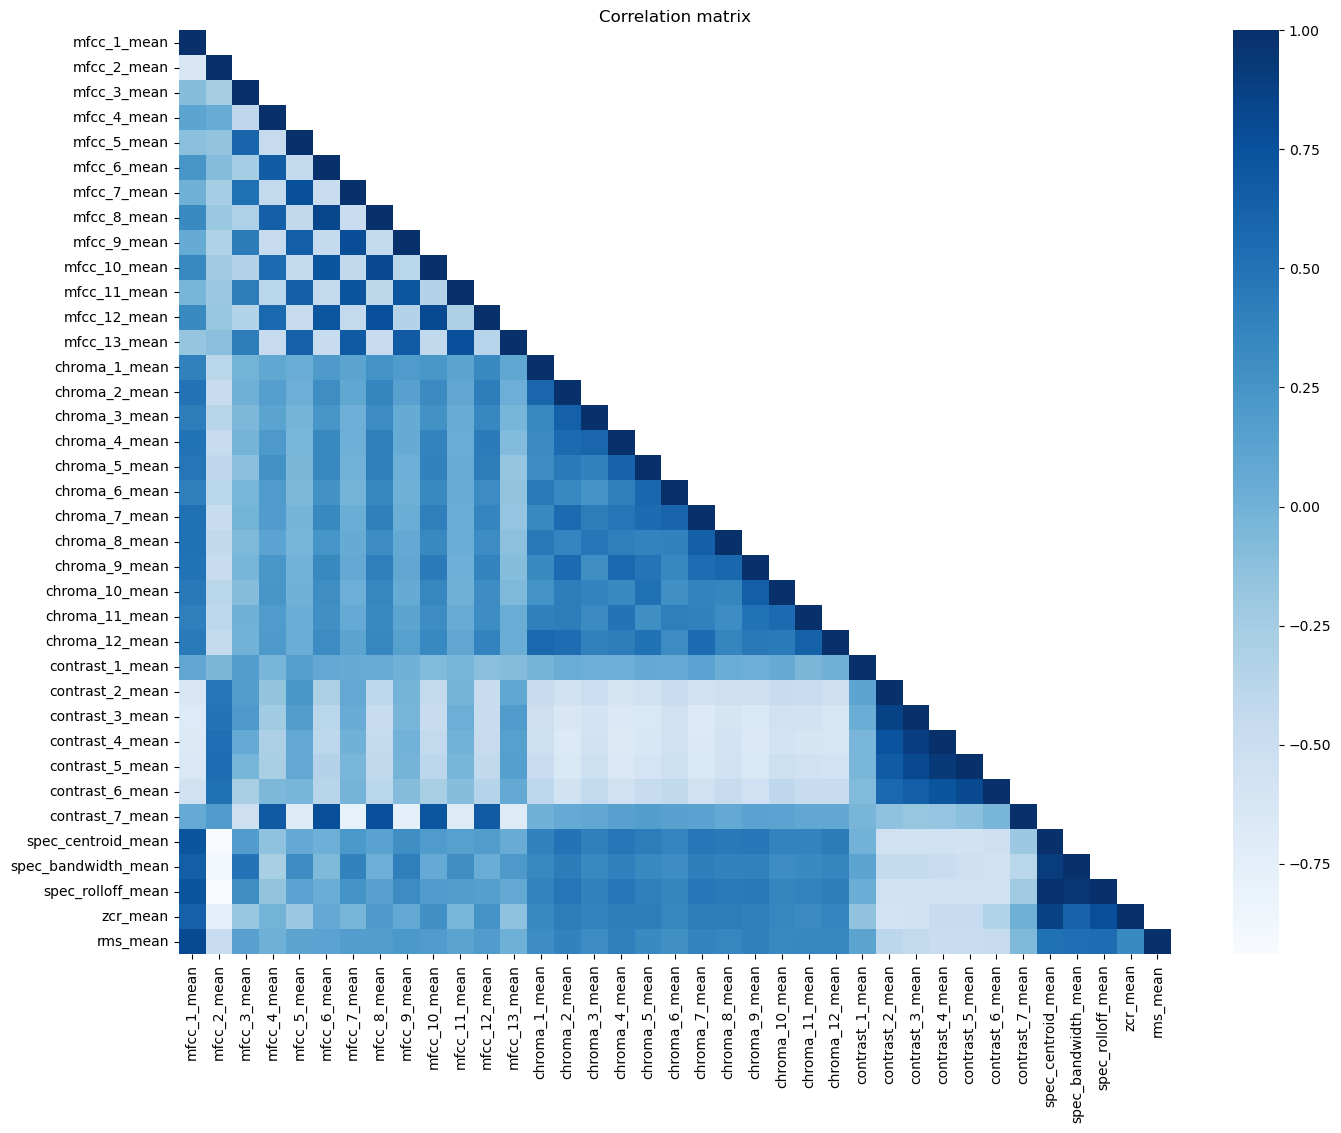

In [6]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr_mean_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix")
plt.show()

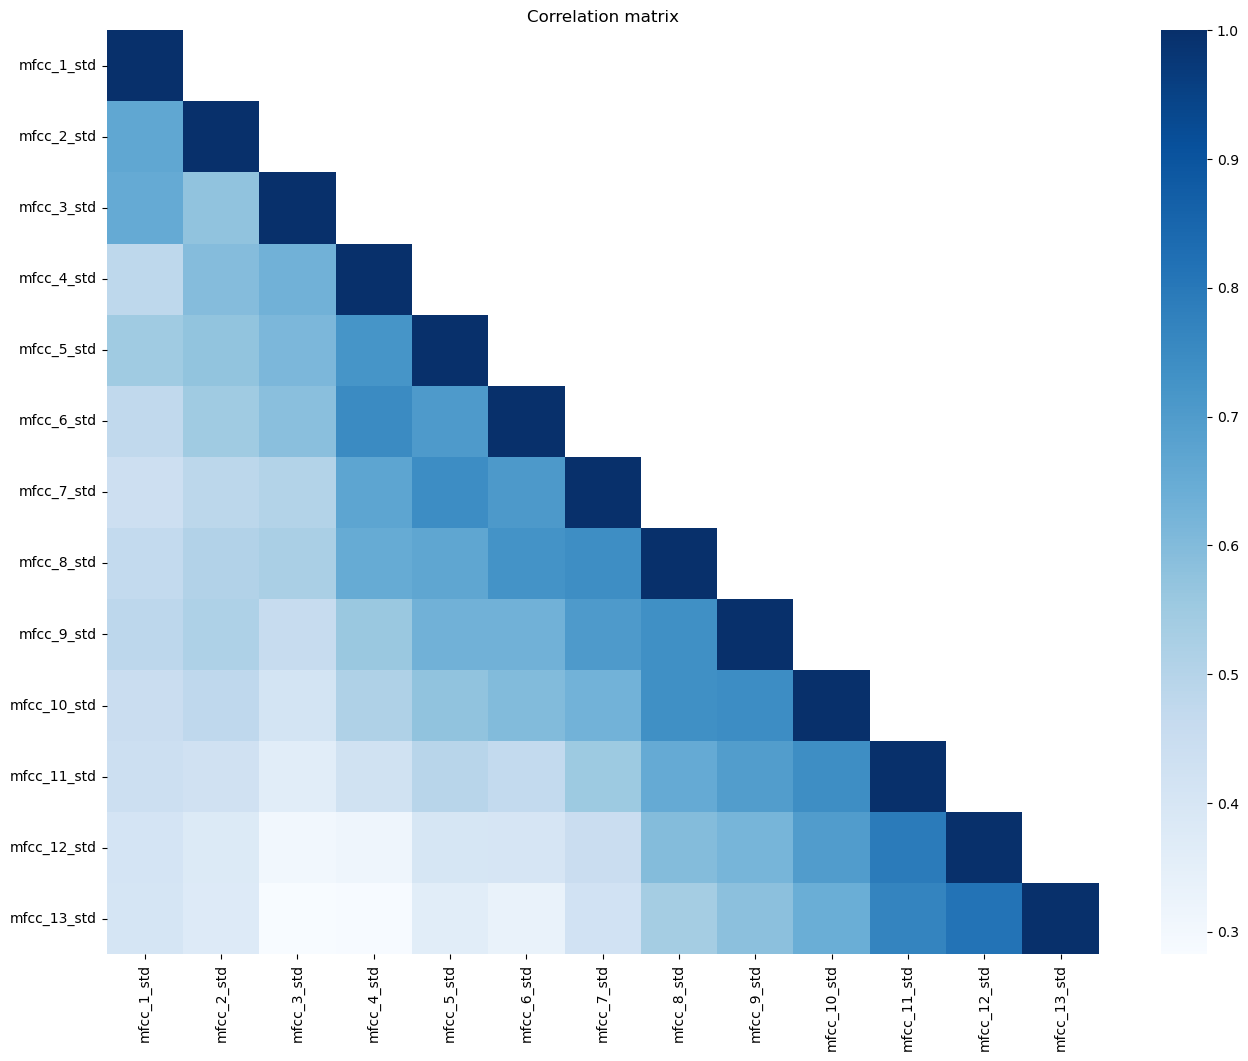

In [7]:
plt.figure(figsize=(16, 12))
sns.heatmap(corr_std_lower, cmap='Blues', annot=False)
plt.title("Correlation matrix")
plt.show()

In [8]:
# "mean" features pairs with correlation > 0.9 
threshold = 0.85
corr_pairs = corr_mean.abs().unstack().sort_values(ascending=False)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]

pd.set_option('display.max_rows', None)
display(high_corr)

spec_rolloff_mean    spec_centroid_mean     0.979621
spec_centroid_mean   spec_rolloff_mean      0.979621
spec_bandwidth_mean  spec_rolloff_mean      0.956278
spec_rolloff_mean    spec_bandwidth_mean    0.956278
spec_centroid_mean   mfcc_2_mean            0.940176
mfcc_2_mean          spec_centroid_mean     0.940176
spec_rolloff_mean    mfcc_2_mean            0.934289
mfcc_2_mean          spec_rolloff_mean      0.934289
contrast_4_mean      contrast_5_mean        0.919751
contrast_5_mean      contrast_4_mean        0.919751
spec_centroid_mean   spec_bandwidth_mean    0.904512
spec_bandwidth_mean  spec_centroid_mean     0.904512
mfcc_2_mean          spec_bandwidth_mean    0.896706
spec_bandwidth_mean  mfcc_2_mean            0.896706
contrast_4_mean      contrast_3_mean        0.892122
contrast_3_mean      contrast_4_mean        0.892122
zcr_mean             spec_centroid_mean     0.874667
spec_centroid_mean   zcr_mean               0.874667
contrast_3_mean      contrast_2_mean        0.

In [9]:
# "std" features pairs with correlation > 0.9 
threshold = 0.9
corr_pairs = corr_std.abs().unstack().sort_values(ascending=False)
high_corr = corr_pairs[(corr_pairs < 1.0) & (corr_pairs > threshold)]

pd.set_option('display.max_rows', None)
display(high_corr)

Series([], dtype: float64)

In [10]:
# Highly correlated features that can cause redundance
df_rf = df.drop(['spec_rolloff_mean', 'spec_bandwidth_mean'], axis=1)

## Random Forest

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
import pandas as pd
import joblib

In [27]:
X = df_rf.drop('genre', axis=1)
y = df_rf['genre']

In [28]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Random Forest parameters grid
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'criterion': ['entropy', 'log_loss'],
    'max_depth': [None, 20, 40, 60],
    'bootstrap': [False, True],
}

rf = RandomForestClassifier(random_state=42)

# Setup HalvingGridSearchCV with cross-validation 
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = HalvingGridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=inner_cv,
    factor=3,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy',  # 'f1', 'roc_auc', ecc.
    verbose=1
)

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print("\n Best parameters:")
print(grid_search.best_params_)

print("\n Accuracy:", accuracy_score(y_test, y_pred))
# print("\n Classification Report:")
# print(classification_report(y_test, y_pred, target_names=le.classes_))

joblib.dump(grid_search.best_estimator_, '../models/test1_best_rf_model.pkl')
print("\n Best model saved in '../models/test1_best_rf_model.pkl'")

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['iter', 'mean_test_score'], ascending=[True, False])

print("\n Details:\n")
for i, row in cv_results_df.iterrows():
    print(f"Iter. {row['iter']}: mean_test_score = {row['mean_test_score']:.4f}")
    print(f"  Parameters: {row['params']}")
    print("-" * 60)


n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 100
max_resources_: 799
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 48
n_resources: 100
Fitting 5 folds for each of 48 candidates, totalling 240 fits
----------
iter: 1
n_candidates: 16
n_resources: 300
Fitting 5 folds for each of 16 candidates, totalling 80 fits

 Best parameters:
{'bootstrap': False, 'criterion': 'log_loss', 'max_depth': 40, 'n_estimators': 1500}

 Best model saved in '../models/test1_best_rf_model.pkl'

 Details:

Iter. 0: mean_test_score = 0.4768
  Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1000}
------------------------------------------------------------
Iter. 0: mean_test_score = 0.4768
  Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'n_estimators': 1500}
------------------------------------------------------------
Iter. 0: mean_test_score = 0.4768
  Parameters: {'bootstrap':

In [34]:
rf_best = grid_search.best_estimator_

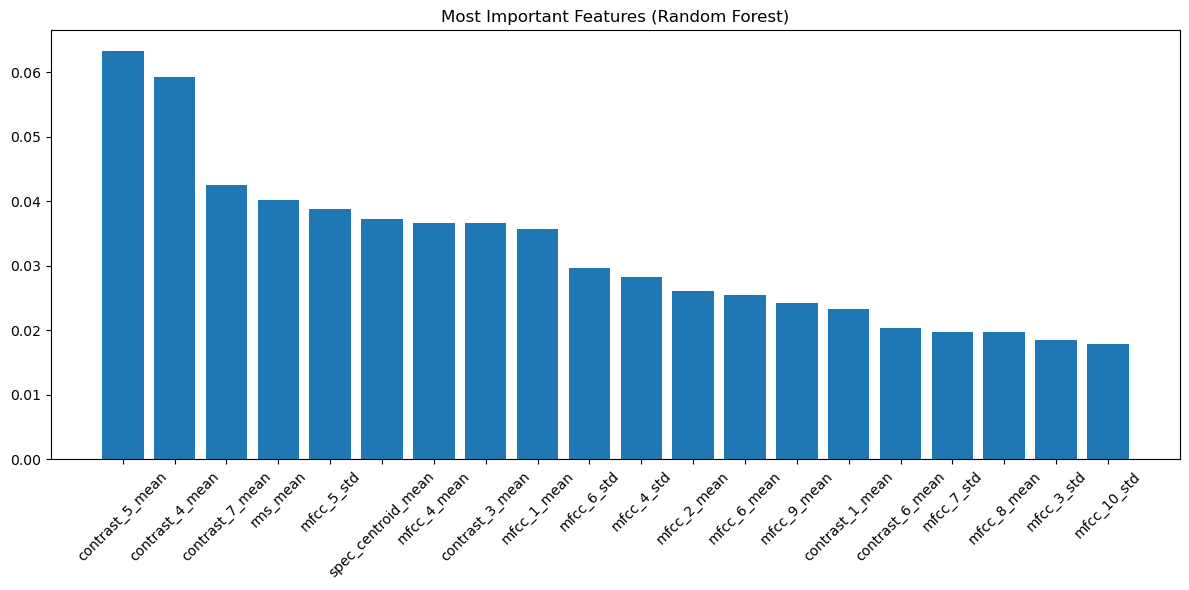

In [35]:
# Most important features

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title("Most Important Features (Random Forest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [features[i] for i in indices[:20]], rotation=45)
plt.tight_layout()
plt.show()

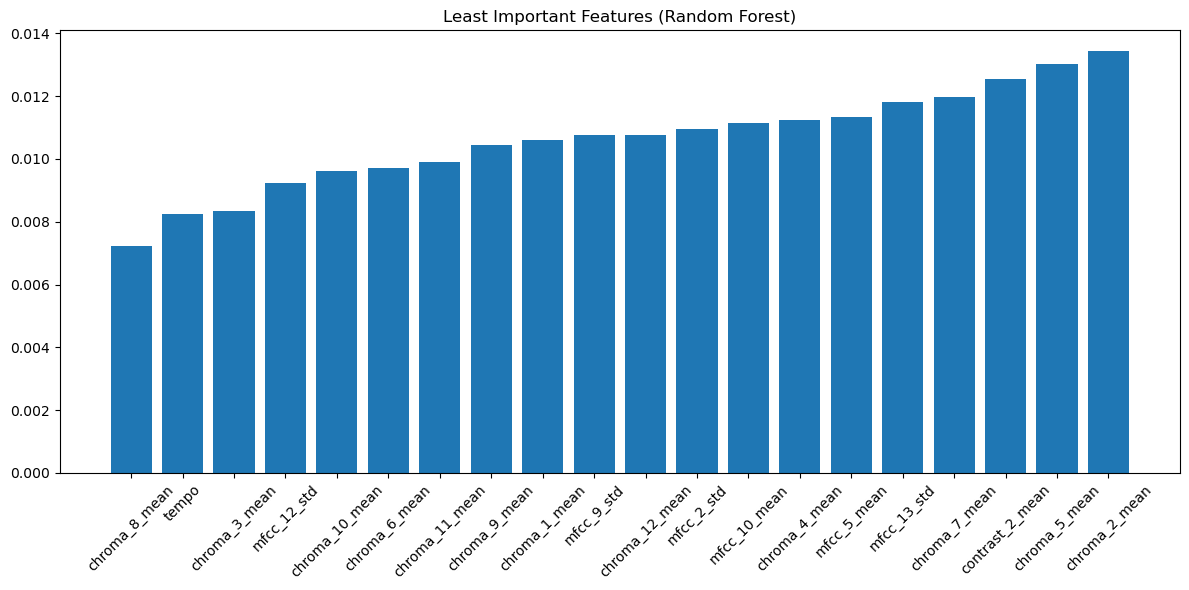

In [36]:
# Least important features

importances = rf_best.feature_importances_
indices = np.argsort(importances)  
features = X.columns

plt.figure(figsize=(12, 6))
plt.title("Least Important Features (Random Forest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), [features[i] for i in indices[:20]], rotation=45)
plt.tight_layout()
plt.show()